In [1]:
import cometspy as c
import matplotlib as plt
import cobra.test
import cobra
import pandas as pd
import numpy as np

In [2]:
# Create empty test tube 
flask = c.layout()

# Set up DM25 media
flask.add_typical_trace_metabolites()
flask.set_specific_metabolite('glc__D_e', 0.000139)
flask.set_specific_metabolite('cit_e', 0.0017)

building empty layout model
models will need to be added with layout.add_model()


In [3]:
# Load the E. coli iJO1366 model 
model  = cobra.test.create_test_model('ecoli')

# Set exchange reaction lower bounds to -1000 to allow them being controlled by COMETS 
for i in model.reactions:
    if 'EX_' in i.id:
        i.lower_bound =-1000.0

Using license file /home/vilacelestin/gurobi.lic
Academic license - for non-commercial use only


In [4]:
# SUCCt2_3pp reaction is inactive in all genotypes; change its bounds to 0
model.reactions.SUCCt2_3pp.upper_bound=0.0

# copy the model to create the genotype with both citT and dctA available
CitTdctA = model.copy()
CitTdctA.id = 'Cit++'

# now make dctA unavailable to create the mutant only expressing citT
model.reactions.SUCCt2_2pp.upper_bound =0.0
CitT = model.copy()
CitT.id = 'Cit+'

# finally, make citT unavailable to create the wild-type genotype
model.reactions.CITt7pp.upper_bound =0.0
WT = model.copy()
WT.id= 'Ancestor' 

Read LP format model from file /tmp/tmpu26lm82l.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmpai46ella.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmp8ttlgsl9.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros


In [5]:
# Generate comets model for the WT
wt = c.model(WT)
wt.initial_pop = [0, 0, 3.9e-11] 

citT = c.model(CitT)
citT.initial_pop = [0, 0, 0] # not present at start

citTdctA = c.model(CitTdctA)
citTdctA.initial_pop = [0, 0, 0] # not present at start

In [6]:
# set vmax for WT
wt.change_vmax('EX_nh4_e',1000)
wt.change_vmax('EX_o2_e',1000)
wt.change_vmax('EX_h_e',1000) 

# set vmax for citT
citT.change_vmax('EX_nh4_e',1000)
citT.change_vmax('EX_o2_e',1000)
citT.change_vmax('EX_h_e',1000) 

citTdctA.change_vmax('EX_nh4_e',1000)
citTdctA.change_vmax('EX_o2_e',1000)
citTdctA.change_vmax('EX_h_e',1000) 


In [7]:
flask.add_model(wt)
flask.add_model(citT)
flask.add_model(citTdctA)

In [8]:
# Setting paramaters for the simulation
b_params = c.params()
b_params.set_param('timeStep', 1.0) 
b_params.set_param('deathRate', 0.01)
b_params.set_param('batchDilution', True)
b_params.set_param('dilTime', 24)
b_params.set_param('dilFactor', 100)

one_cell = 3.9e-13 # gr. dry weight of an E. coli cell 
b_params.set_param('cellSize', one_cell)
b_params.set_param('minSpaceBiomass', 3.8e-13)  # <1cell 

In [9]:
# number of simulation cycles per day  
cycles_per_day = 24.0/b_params.all_params['timeStep']

sim = c.comets(flask, b_params)
sim.parameters.set_param('maxCycles', int(900*cycles_per_day))
sim.run()
# Create dataframe with population dynamics from phase 1
phase_1 = pd.DataFrame({'Ancestor' : sim.total_biomass.Ancestor/one_cell,
                        'CitT' : sim.total_biomass['Cit+']/one_cell,
                        'CitTdctA' : sim.total_biomass['Cit++']/one_cell,
                        'Generations' : 6.67*(sim.total_biomass.cycle+1)/cycles_per_day + 25000})



Running COMETS simulation ...
Done!


In [10]:
# The initial population size for the wild type will be its final population size from the previous phase. 
sim.layout.models[0].initial_pop = [0, 0, float(sim.total_biomass.Ancestor.tail(1))]

# Introduce new genotypes 100 cells at a time to avoid the risk of them drifting to extinction
sim.layout.models[1].initial_pop = [0, 0, one_cell*100]


# Running build_initial_pop is essential when we change the initial population sizes of models that are already loaded into a layout
sim.layout.build_initial_pop()


# Change the cycles 
sim.parameters.set_param('maxCycles', int(300*cycles_per_day))
sim.run()
phase_2 = pd.DataFrame({'Ancestor' : sim.total_biomass.Ancestor/one_cell,
                        'CitT' : sim.total_biomass['Cit+']/one_cell,
                        'CitTdctA' : sim.total_biomass['Cit++']/one_cell,
                        'Generations' : 6.67*(sim.total_biomass.cycle)/cycles_per_day + max(phase_1.Generations)})


Running COMETS simulation ...
Done!


In [11]:
sim.layout.models[0].initial_pop = [0, 0, float(sim.total_biomass.Ancestor.tail(1))]
sim.layout.models[1].initial_pop = [0, 0, float(sim.total_biomass['Cit+'].tail(1))]
sim.layout.models[2].initial_pop = [0, 0, 3.9e-11]
sim.layout.build_initial_pop()
sim.parameters.set_param('maxCycles', int(900*cycles_per_day))
sim.run()
phase_3 = pd.DataFrame({'Ancestor' : sim.total_biomass.Ancestor/(3.9e-13),
                        'CitT' : sim.total_biomass['Cit+']/(3.9e-13),
                        'CitTdctA' : sim.total_biomass['Cit++']/(3.9e-13),
                        'Generations' : 6.67*(sim.total_biomass.cycle)/cycles_per_day + max(phase_2.Generations) }) 



Running COMETS simulation ...
Done!


[Text(0, 0, '0'),
 Text(0, 0, '1 x $10^8$'),
 Text(0, 0, '2 x $10^8$'),
 Text(0, 0, '3 x $10^8$')]

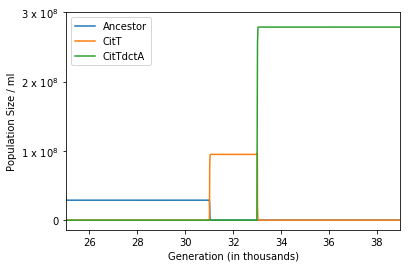

In [14]:
# Remove the final timepoint from each phase and merge them together to plot
phase_1.drop(phase_1.tail(1).index, inplace=True)
phase_2.drop(phase_2.tail(1).index, inplace=True)
phase_3.drop(phase_3.tail(1).index, inplace=True)
final_df = pd.concat([phase_1,phase_2,phase_3])
final_df.reindex()

# Subset to only plot final timepoint within each transfer and convet generation into thousands
final_df = final_df[np.round((final_df.Generations - 25000) % 6.67,3) == 6.67]
final_df.Generations = final_df.Generations/1000

# Plot
fig = final_df.plot(x='Generations')
fig.set_xlabel('Generation (in thousands)')
fig.set_ylabel('Population Size / ml')
fig.set_yticks([0,1e+08,2e+08,3e+08])
fig.set_yticklabels(['0','1 x $10^8$','2 x $10^8$','3 x $10^8$'])